In [13]:
import sparse
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

In [2]:
files = sorted(glob.glob("*.npz"))

In [3]:
len(files)

10

In [10]:
data_folder = 'data/'
products_indices = list(range(6, 12)) + list(range(17, 24)) # R, V and VIL products

def split_data_in_files_per_timestep():
    os.makedirs(data_folder, exist_ok=True)

    for file in files:
        content = None # clear cache for this variable (to solve memory error when running cell several consecutive times)
        content = sparse.load_npz(file).todense()
        timesteps = content.shape[0]
        
        print(content.shape)
    
        for i in range(0, timesteps):
            file_name = file.split('-')[0].split('_')
            file_name = file_name[len(file_name) - 1] + "_" + str(i) + '.npz'
          
            timestep_value = sparse.COO(content[i, :, :, products_indices])
            sparse.save_npz(os.path.join(data_folder, file_name), timestep_value)
        
        break # stop after saving first day of data
        
# split_data_in_files_per_timestep() 

In [11]:
timesteps_files = sorted(glob.glob(os.path.join(data_folder, '*.npz')))

(13, 624, 800)


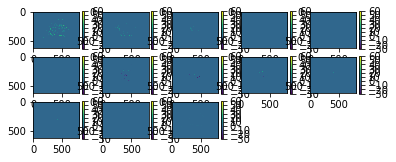

In [17]:
def plot_cube_product(cube:np.ndarray, product_index):
    mat = cube[product_index, :, :]
    plt.imshow(mat, vmin=-30, vmax=60)

    plt.colorbar(orientation='vertical')
    plt.show()

def plot_cube(cube: np.ndarray):
    for i in range(1, cube.shape[0]+1):
        plt.subplot(5, 5, i)
        mat = cube[i-1, :, :]
        
        plt.imshow(mat, vmin=-30, vmax=60)
        plt.colorbar(orientation='vertical')
        
    plt.show()

    
for file in timesteps_files:
    content = None
    content = sparse.load_npz(file).todense()
    
    plot_cube(content)
    
    break

In [2]:
import tensorflow as tf
import numpy as np

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_IDs, labels, batch_size=32, dim=(624, 800), n_channels=13, n_classes=10, shuffle=False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.array(sparse.load_npz(ID).todense(), dtype=float)# np.load('data/' + ID + '.npz')

            # Store output
            y[i] = np.array(sparse.load_npz(self.labels[ID]).todense(), dtype=float)

        return X, y
    
    

In [3]:
all_data = sorted(glob.glob(os.path.join('data', '*.npz')))
content = np.array(sparse.load_npz(all_data[0]).todense(), dtype=float)
current_shape = content.shape
content = content.reshape((current_shape[1], current_shape[2], current_shape[0]))

# fig, ax = plt.subplots(content.shape[2], 1)

# for d in range(1):
#     ax[d].matshow(content[:, :, d], cmap=plt.cm.Blues)

#     for i in range(content.shape[0]):
#         for j in range(content.shape[1]):
#             c = content[i, j, d]
#             ax[d].text(i, j, str(c), va='center', ha='center')

In [27]:
all_data.sort(key= lambda x: int(x.split('_')[1].split('.')[0]))

val_size = int(0.1 * len(all_data))
val_data = all_data[-val_size:]
train_data = all_data[:-val_size]
val_labels = {}
train_labels = {}

for i in range(len(val_data)-1):
    val_labels[val_data[i]] = val_data[i+1]

val_data = val_data[:-1]

for i in range(len(train_data)-1):
    train_labels[train_data[i]] = train_data[i+1]

train_data = train_data[:-1]

# Parameters
params = {'dim': (content.shape[0], content.shape[1]),
          'batch_size': 16,
          'n_channels': 13}

# Datasets
partition = {
    'train': train_data,
    'validation': val_data
}

labels = {
    'train': train_labels,
    'validation': val_labels
}

# Generators
training_generator = DataGenerator(partition['train'], labels['train'], **params)
validation_generator = DataGenerator(partition['validation'], labels['validation'], **params)

# Design model
model = Sequential()
[...] # Architecture
model.compile()

# Train model on dataset
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=6)

{'data\\20170603_0.npz': 'data\\20170603_1.npz',
 'data\\20170603_1.npz': 'data\\20170603_2.npz',
 'data\\20170603_2.npz': 'data\\20170603_3.npz',
 'data\\20170603_3.npz': 'data\\20170603_4.npz',
 'data\\20170603_4.npz': 'data\\20170603_5.npz',
 'data\\20170603_5.npz': 'data\\20170603_6.npz',
 'data\\20170603_6.npz': 'data\\20170603_7.npz',
 'data\\20170603_7.npz': 'data\\20170603_8.npz',
 'data\\20170603_8.npz': 'data\\20170603_9.npz',
 'data\\20170603_9.npz': 'data\\20170603_10.npz',
 'data\\20170603_10.npz': 'data\\20170603_11.npz',
 'data\\20170603_11.npz': 'data\\20170603_12.npz',
 'data\\20170603_12.npz': 'data\\20170603_13.npz',
 'data\\20170603_13.npz': 'data\\20170603_14.npz',
 'data\\20170603_14.npz': 'data\\20170603_15.npz',
 'data\\20170603_15.npz': 'data\\20170603_16.npz',
 'data\\20170603_16.npz': 'data\\20170603_17.npz',
 'data\\20170603_17.npz': 'data\\20170603_18.npz',
 'data\\20170603_18.npz': 'data\\20170603_19.npz',
 'data\\20170603_19.npz': 'data\\20170603_20.npz',